In [1]:
from __future__ import print_function

import argparse
import torch
import pickle 
import numpy as np 
import os 
import math 
import random 
import sys
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.io

import data 

from sklearn.decomposition import PCA
from torch import nn, optim
from torch.nn import functional as F

from detm import DETM
from utils import nearest_neighbors, get_topic_coherence

import pandas as pd

device: cuda:3
device: cuda:3


In [2]:
from sklearn import cluster
from sklearn import metrics

In [3]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [4]:
root_dir = '/home/yiyi/nlp_tm/'

In [5]:
def load_data(input_dir= os.path.join(root_dir, 'preprocessed_data')):
    token_file = os.path.join(input_dir, 'bow_tokens')
    count_file = os.path.join(input_dir, 'bow_counts')
    time_file = os.path.join(input_dir, 'bow_timestamps')
    tokens = scipy.io.loadmat(token_file)['tokens'].squeeze()
    counts = scipy.io.loadmat(count_file)['counts'].squeeze()
    times = scipy.io.loadmat(time_file)['timestamps'].squeeze()
    
    return tokens, counts, times


In [6]:
tokens, counts, times = load_data()

In [7]:
def _eta_helper(rnn_inp):
    inp = model.q_eta_map(rnn_inp).unsqueeze(1)
    hidden = model.init_hidden()
    output, _ = model.q_eta(inp, hidden)
    output = output.squeeze()
    etas = torch.zeros(model.num_times, model.num_topics).to(device)
    inp_0 = torch.cat([output[0], torch.zeros(model.num_topics,).to(device)], dim=0)
    etas[0] = model.mu_q_eta(inp_0)
    for t in range(1, model.num_times):
        inp_t = torch.cat([output[t], etas[t-1]], dim=0)
        etas[t] = model.mu_q_eta(inp_t)
    return etas

In [8]:
filepath = 'results/detm_twitter_K_75_Htheta_800_Optim_adam_Clip_0.0_ThetaAct_relu_Lr_0.005_Bsz_1000_RhoSize_300_L_3_minDF_10_trainEmbeddings_1_val_ppl_2741.7_epoch_14'

In [9]:
model_path = os.path.join('/home/yiyi/nlp_tm/', filepath)

In [10]:
with open(model_path, 'rb') as f:
    model = torch.load(f)

In [11]:
model.to(device)

DETM(
  (t_drop): Dropout(p=0.0, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=20865, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=20940, out_features=800, bias=True)
    (1): ReLU()
    (2): Linear(in_features=800, out_features=800, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=800, out_features=75, bias=True)
  (logsigma_q_theta): Linear(in_features=800, out_features=75, bias=True)
  (q_eta_map): Linear(in_features=20865, out_features=200, bias=True)
  (q_eta): LSTM(200, 200, num_layers=3)
  (mu_q_eta): Linear(in_features=275, out_features=75, bias=True)
  (logsigma_q_eta): Linear(in_features=275, out_features=75, bias=True)
)

In [12]:
with open(os.path.join('/home/yiyi/nlp_tm/preprocessed_data', 'vocab.pkl'), 'rb') as f:
        vocab = pickle.load(f)

In [13]:
vocab_size = len(vocab)

In [14]:
len(tokens)

360097

In [15]:
indices = torch.split(torch.tensor(range(len(tokens))), 1000)

In [16]:
# get the centroid of words
keywords=  [ 'immigrant', 'immigrants',  'refugee', 'refugees','asylum',
      'migrant', 'migrants', 'internally displaced', 'UNHCR', 'asylee',
      'asylees', 'Asylee',  'resettled', 'resettlements',
      'immigration', 'Ateh', 're settlement', 'resettle', 'resettles', 'statelessness', 'Hagadera' , 'Domiz',
      'émigré', 'exile', 'displaced person', 'deserter', 'pariah', 'pariahs' ]
# keywords = ['immigrant', 'refugee']
keywords = list(set([k.lower() for k in keywords]))

keywords_selected = []
for k in keywords: 
    if k in vocab:
        keywords_selected.append(k)

In [17]:
keywords_selected

['statelessness',
 'pariahs',
 'resettle',
 'refugee',
 'immigrants',
 'deserter',
 'asylee',
 'refugees',
 'migrant',
 'immigration',
 'immigrant',
 'unhcr',
 'resettled',
 'pariah',
 'migrants',
 'exile',
 'asylum']

In [18]:
def get_centroid_vector(embeddings, keywords):
    # vectors of whole embeddings.
    indexes_keywords = [vocab.index(word) for word in keywords]
    queries = [embeddings[index] for index in indexes_keywords] # vectors of the keywords
    kmeans = cluster.KMeans(n_clusters=1, random_state=0).fit(queries)
    centroid = kmeans.cluster_centers_[0]
    print('centroid size: ', centroid.shape)
    return centroid

In [19]:
from numpy import dot
from numpy.linalg import norm
def cosine_similarity(list_1, list_2):
    cos_sim = dot(list_1, list_2) / (norm(list_1) * norm(list_2))
    return cos_sim

In [20]:
def nearest_neighbors(word, vectors, vocab, num_words):
    index = vocab.index(word)
    query = embeddings[index]
    ranks = vectors.dot(query).squeeze()
    denom = query.T.dot(query).squeeze()
    denom = denom * np.sum(vectors**2, 1)
    denom = np.sqrt(denom)
    ranks = ranks / denom
    print(np.sort(ranks)[::-1][:num_words])
    mostSimilar = []
    [mostSimilar.append(idx) for idx in ranks.argsort()[::-1]]
    nearest_neighbors = mostSimilar[:num_words]
    nearest_neighbors = [vocab[comp] for comp in nearest_neighbors]
    print(nearest_neighbors)
    return nearest_neighbors

In [21]:
model.eval()
with torch.no_grad():
    # rnn_inp = data.get_rnn_input(tokens, counts, times, 8, vocab_size, len(tokens)).to(device)
    # etas = _eta_helper(rnn_inp).to(device)
    embeddings = model.rho.weight
    embeddings= embeddings.cpu().numpy()

In [40]:
indexes_keywords = [vocab.index(word) for word in keywords_selected]
queries = [embeddings[index] for index in indexes_keywords] #

In [41]:
kmeans = cluster.KMeans(n_clusters=1, random_state=0).fit(queries)
centroid = kmeans.cluster_centers_[0]

In [42]:
ranks= embeddings.dot(centroid).squeeze()
denom = centroid.T.dot(centroid).squeeze()
denom = denom*np.sum(embeddings*2, 1)
ranks = ranks/denom
mostSimilar = []
[mostSimilar.append(idx) for idx in ranks.argsort()[::-1]]
nearest_neighbors = mostSimilar[:20]
nearest_neighbors = [vocab[comp] for comp in nearest_neighbors]
nearest_neighbors

['bark',
 'pep',
 'jingoistic',
 'scorch',
 'winston',
 'israels',
 'judgemental',
 'kickoff',
 'nl',
 'foreignpolicy',
 'statelessnesscancelled',
 'srhr',
 'psychiatrist',
 'gandhi',
 'debilitate',
 'smokescreen',
 'lent',
 'authorize',
 'mono',
 'humantrafficke']

In [43]:
neigh_indices = [vocab.index(word) for word in nearest_neighbors]
neigh_q = [embeddings[index] for index in neigh_indices] 

In [44]:
len(neigh_q)

20

In [45]:
len(queries)

17

In [46]:
len(keywords_selected)

17

In [47]:
queries.append(centroid)

In [48]:
len(queries)

18

In [54]:
n = queries+neigh_q
n_arr = np.array(n)

In [55]:
n_arr.shape

(38, 300)

In [57]:
ks =keywords_selected+['centroid']+nearest_neighbors

In [58]:
len(ks)

38

In [59]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=7)
T = tsne.fit_transform(n_arr)

In [64]:
colors = ['blue' for x in range(0,17)]+['red']+['orange' for x in range(0,20) ]

In [61]:
len(colors)

38

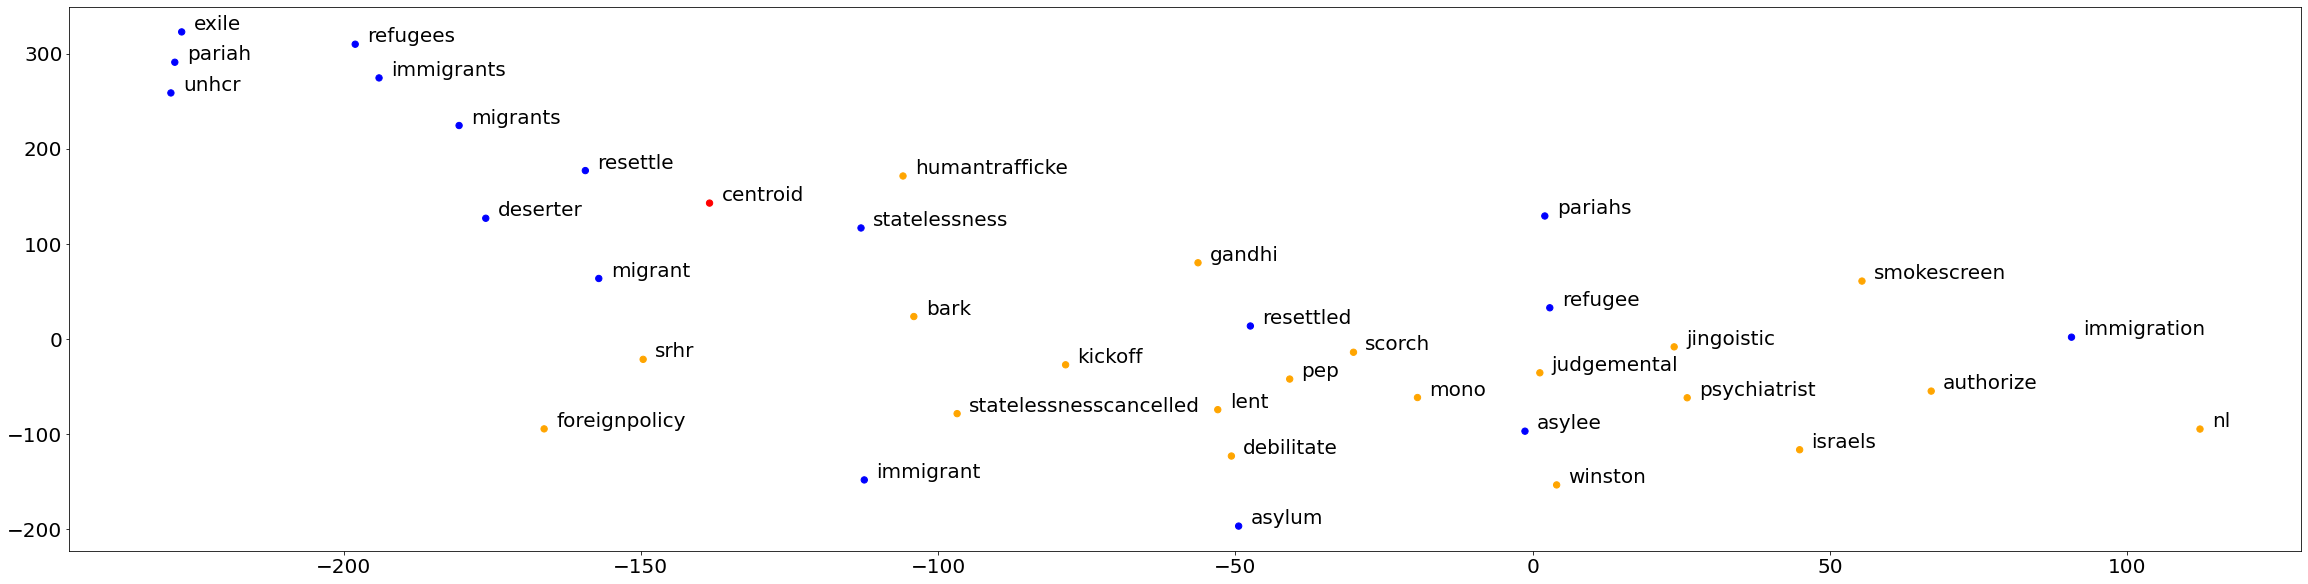

In [102]:
plt.figure(figsize=(40,10))
plt.scatter(T[:, 0], T[:, 1], s=40, c=colors)

for label, x, y in zip(ks, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+2, y+2), xytext=(0, 0), textcoords='offset points', fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('images/dist_emb_detm_k-75.png')

In [85]:
confidences =[]
model.eval()
with torch.no_grad():
    rnn_inp = data.get_rnn_input(tokens, counts, times, 8, vocab_size, len(tokens)).to(device)
    etas = _eta_helper(rnn_inp).to(device)
#     embeddings = model.rho.weight
#     embeddings= embeddings.cpu().numpy()
#     indexes_keywords = [vocab.index(word) for word in keywords]
#     queries = [embeddings[index] for index in indexes_keywords] # vectors of the keywords
#     print(cosine_similarity(queries[0], queries[1]))
#     centroid = get_centroid_vector(embeddings, keywords_selected)

    for idx, ind in enumerate(indices):
        data_batch, times_batch = data.get_batch(
                        tokens, counts, ind, len(vocab),300, temporal=True, times=times)
        sums = data_batch.sum(1).unsqueeze(1)
        normalized_data_batch = data_batch / sums
        eta_td = etas[times_batch.type('torch.LongTensor')].to(device)
        inp = torch.cat([eta_td, normalized_data_batch], dim=1).to(device)
        q_theta = model.q_theta(inp) # 1000, 800
        lr = nn.Linear(q_theta.shape[1], 300).to(device)
        mu_theta = lr(q_theta).cpu().numpy()
        for i in mu_theta:
            cos = cosine_similarity(i, centroid)
            confidences.append(cos)

        # mu_theta = model.mu_q_theta(q_theta) # 1000, 75
        print(q_theta.shape)
        print(mu_theta.shape)



idx: 0/361
idx: 20/361
idx: 40/361
idx: 60/361
idx: 80/361
idx: 100/361
idx: 120/361
idx: 140/361
idx: 160/361
idx: 180/361
idx: 200/361
idx: 220/361
idx: 240/361
idx: 260/361
idx: 280/361
idx: 300/361
idx: 320/361
idx: 340/361
idx: 360/361
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
tor

In [86]:
len([x for x in confidences if x>0])

177192

In [87]:
len([x for x in confidences if x>0])

177192

In [88]:
df = pd.read_csv(os.path.join(root_dir, 'datasets/df_detm_topics_k25.csv'), index_col=0)

In [89]:
df.head()

,text_id,year_id,country_code,id.1,text,created_at,geo,author_id,entities,year,month,day,preprocessed_text,topic
id,,,,,,,,,,,,,,
285908615561363456,"[13807, 12242, 16517, 4854, 16885, 13840, 7284...",0,GB,285908615561363456,"Completely missed the New Year beginning, too ...",2013-01-01T00:41:40.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",174028844,"{'hashtags': [{'start': 59, 'end': 80, 'tag': ...",2013,1,1,completely miss new year beginning engross car...,11
285909630868152320,"[11403, 16517, 13618, 1431, 1404, 1881]",0,DE,285909630868152320,happy new year all of you who lives in #europe...,2013-01-01T00:45:42.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",615040794,"{'hashtags': [{'start': 39, 'end': 46, 'tag': ...",2013,1,1,happy new year live europe party start right,11
285915248383361026,"[638, 2601, 20286]",0,GB,285915248383361026,Damien Sandow is awesome #YoureWelcome,2013-01-01T01:08:01.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",73127632,"{'annotations': [{'start': 0, 'end': 12, 'prob...",2013,1,1,damien sandow awesome yourewelcome,11
285921849446117376,"[17018, 9987]",0,GB,285921849446117376,Ryan was looking at me like I needed to be in ...,2013-01-01T01:34:15.000Z,"{'place_id': 'a3f4491c1a3bfe66', 'coordinates'...",398595226,"{'annotations': [{'start': 0, 'end': 3, 'proba...",2013,1,1,ryan look like need asylum troublemaker come,11
285922536942866432,"[2721, 16517, 12121]",0,GB,285922536942866432,#welcome #to #2013 #i #hope #this #year #is #b...,2013-01-01T01:36:59.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",191530036,"{'hashtags': [{'start': 0, 'end': 8, 'tag': 'w...",2013,1,1,welcome hope year well litte world know,11


In [90]:
len(df)

360097

In [91]:
df['cossim']= confidences

In [99]:
df[df['cossim']>=0.0]

,text_id,year_id,country_code,id.1,text,created_at,geo,author_id,entities,year,month,day,preprocessed_text,topic,cossim
id,,,,,,,,,,,,,,,
285908615561363456,"[13807, 12242, 16517, 4854, 16885, 13840, 7284...",0,GB,285908615561363456,"Completely missed the New Year beginning, too ...",2013-01-01T00:41:40.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",174028844,"{'hashtags': [{'start': 59, 'end': 80, 'tag': ...",2013,1,1,completely miss new year beginning engross car...,11,0.045408
285909630868152320,"[11403, 16517, 13618, 1431, 1404, 1881]",0,DE,285909630868152320,happy new year all of you who lives in #europe...,2013-01-01T00:45:42.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",615040794,"{'hashtags': [{'start': 39, 'end': 46, 'tag': ...",2013,1,1,happy new year live europe party start right,11,0.051313
285915248383361026,"[638, 2601, 20286]",0,GB,285915248383361026,Damien Sandow is awesome #YoureWelcome,2013-01-01T01:08:01.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",73127632,"{'annotations': [{'start': 0, 'end': 12, 'prob...",2013,1,1,damien sandow awesome yourewelcome,11,0.045467
285921849446117376,"[17018, 9987]",0,GB,285921849446117376,Ryan was looking at me like I needed to be in ...,2013-01-01T01:34:15.000Z,"{'place_id': 'a3f4491c1a3bfe66', 'coordinates'...",398595226,"{'annotations': [{'start': 0, 'end': 3, 'proba...",2013,1,1,ryan look like need asylum troublemaker come,11,0.049960
285922536942866432,"[2721, 16517, 12121]",0,GB,285922536942866432,#welcome #to #2013 #i #hope #this #year #is #b...,2013-01-01T01:36:59.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",191530036,"{'hashtags': [{'start': 0, 'end': 8, 'tag': 'w...",2013,1,1,welcome hope year well litte world know,11,0.048133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1343988259765051392,"[2226, 9987]",7,GB,1343988259765051392,@mattybooboo75 Obviously an escapee from the a...,2020-12-29T18:32:25.000Z,"{'place_id': '303c5faf459d938e', 'place': {'fu...",276966717,"{'mentions': [{'start': 0, 'end': 14, 'usernam...",2020,12,29,obviously escapee asylum,16,0.000569
1344012175334137856,"[9791, 15262]",7,GB,1344012175334137856,I know what you did last summer.2020 in Pictur...,2020-12-29T20:07:27.000Z,"{'place_id': '4393349f368f67a1', 'place': {'fu...",2422078142,"{'urls': [{'start': 53, 'end': 76, 'url': 'htt...",2020,12,29,know summer picture,16,0.011009
1344067898088812546,"[11903, 4824]",7,GB,1344067898088812546,@SarcasticoRosso I said similar and I was a pa...,2020-12-29T23:48:53.000Z,"{'place_id': '771940ebb979945f', 'place': {'fu...",1072561979477426178,"{'mentions': [{'start': 0, 'end': 16, 'usernam...",2020,12,29,say similar pariah,16,0.001806


In [93]:
df.to_csv(os.path.join(root_dir, 'datasets/df_detm_topics_k25_confidence.csv'))

In [ ]:
sns.color_palette()

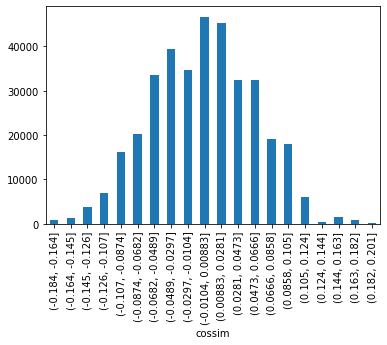

In [94]:
df['text'].groupby(pd.cut(df['cossim'], 20)).count().plot(kind='bar')

In [95]:
df['topic'].value_counts()

16    85755
22    77262
20    53648
17    46619
15    40900
11    28843
3     17307
9      7654
14     1989
24      108
13        7
8         3
4         1
1         1
Name: topic, dtype: int64

In [96]:
samples = df[df['cossim']>=0.01]

In [97]:
len(samples)

153382

In [98]:
len(samples['topic'].value_counts())

14

In [ ]:
samples[samples['topic']==13]

In [ ]:
samples = df[df['cossim']>=0.01].sample(30)

In [ ]:
list(zip(samples.text, samples.cossim, samples.topic))